# 🔥 Perimeter-Evacuation Zone Integration: A Comprehensive Analysis


## Overview

This notebook implements **three different geometric matching approaches** to integrate fire perimeters with evacuation zones from the Watch Duty dataset. We'll explore why each method was chosen, how they work, and their trade-offs between speed and accuracy.

## 📊 Dataset Information

- **Fire Perimeters**: 4,139 approved perimeters from Watch Duty
- **Evacuation Zones**: 33,554 active evacuation zones
- **Geographic Coverage**: Primarily US West Coast
- **Challenge**: Match perimeters to zones when no direct ID relationship exists

---



### Our Solution: Three Geometric Methods
We'll implement three approaches, each with different trade-offs:

1. **Centroid Distance** - Fast and simple
2. **Nearest Vertex** - Considers polygon shape
3. **Boundary-to-Boundary** - Most accurate, exact shortest distance

---


## 📚 Method 1: Centroid Distance Matching

### 🎯 The Concept
**Centroid distance** measures the straight-line distance between the center points (centroids) of two polygons.

### 🧮 The Math Behind It

The centroid of a polygon is calculated as:
```
Centroid = (Σ(x_i) / n, Σ(y_i) / n)
```

Where:
- `x_i, y_i` are the coordinates of each vertex
- `n` is the number of vertices

Distance is calculated using the **Haversine formula** for accuracy on Earth's surface:
```
a = sin²(Δφ/2) + cos(φ1) × cos(φ2) × sin²(Δλ/2)
c = 2 × atan2(√a, √(1−a))
d = R × c
```

Where:
- `φ` is latitude, `λ` is longitude
- `R` is Earth's radius (6,371 km)

---


## 📚 Method 2: Nearest Vertex Matching

### 🎯 The Concept
**Nearest vertex matching** finds the shortest distance between any vertex of one polygon and any vertex of another polygon.

### 🧮 The Math Behind It

For each polygon, we extract all vertices:
```
Vertices = [(x₁, y₁), (x₂, y₂), ..., (xₙ, yₙ)]
```

Then find the minimum distance between any pair:
```
min_distance = min(distance(v₁, v₂)) for all v₁ ∈ polygon1, v₂ ∈ polygon2
```


---


## 📚 Method 3: Boundary-to-Boundary Distance Matching

### 🎯 The Concept
**Boundary-to-boundary matching** finds the exact shortest distance between two polygons by considering all points along their boundaries, not just vertices.

### 🧮 The Math Behind It

This method uses **Shapely's nearest_points()** function, which implements:
1. **Spatial indexing** for efficient point-to-polygon distance calculations
2. **Edge-to-edge distance** calculations
3. **Point-to-edge distance** calculations

The algorithm finds the exact closest points:
```
nearest_point1, nearest_point2 = nearest_points(polygon1, polygon2)
distance = haversine_distance(nearest_point1, nearest_point2)
```


---


## 🛠️ Implementation: Setting Up the Environment

Let's start by importing the necessary libraries and setting up our environment.


In [117]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Geospatial libraries
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.wkt import loads
from shapely.ops import nearest_points

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print("📊 Ready to start the integration analysis!")


✅ Libraries imported successfully!
📊 Ready to start the integration analysis!


## 🔧 Core Geometry Processing Class

Let's implement our geometry processing class that handles all the geometric operations for our three methods.


In [118]:
class GeometryProcessor:
    """
    Handles geometric operations for perimeter-evacuation zone matching.
    
    This class provides all the geometric functions needed for our three
    matching methods: centroid distance, nearest vertex, and boundary-to-boundary.
    """
    
    def __init__(self):
        self.earth_radius_km = 6371.0  # Earth radius in kilometers
    
    def parse_wkt_geometry(self, wkt_string):
        """
        Parse WKT (Well-Known Text) geometry string and return Shapely geometry.
        
        Args:
            wkt_string (str): WKT representation of geometry
            
        Returns:
            Polygon or None: Parsed geometry or None if parsing fails
        """
        try:
            if pd.isna(wkt_string) or not wkt_string:
                return None
            
            # Remove SRID prefix if present (e.g., "SRID=4326;POLYGON(...)")
            if wkt_string.startswith('SRID=4326;'):
                wkt_string = wkt_string[10:]
            
            geometry = loads(wkt_string)
            
            # Convert MultiPolygon to Polygon if needed (take largest)
            if isinstance(geometry, MultiPolygon):
                if len(geometry.geoms) > 0:
                    largest_polygon = max(geometry.geoms, key=lambda p: p.area)
                    return largest_polygon
                else:
                    return None
            elif isinstance(geometry, Polygon):
                return geometry
            else:
                return None
                
        except Exception as e:
            print(f"⚠️  Failed to parse WKT geometry: {e}")
            return None
    
    def calculate_distance_meters(self, point1, point2):
        """
        Calculate distance between two points in meters using Haversine formula.
        
        Args:
            point1 (tuple): (longitude, latitude) of first point
            point2 (tuple): (longitude, latitude) of second point
            
        Returns:
            float: Distance in meters
        """
        try:
            lat1, lon1 = point1
            lat2, lon2 = point2
            
            # Convert to radians
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            
            # Haversine formula
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
            c = 2 * np.arcsin(np.sqrt(a))
            
            # Distance in meters
            distance_km = self.earth_radius_km * c
            return distance_km * 1000
            
        except Exception as e:
            print(f"⚠️  Distance calculation failed: {e}")
            return float('inf')
    
    def get_centroid(self, geometry):
        """
        Get centroid of a polygon as (longitude, latitude).
        
        Args:
            geometry (Polygon): Shapely polygon geometry
            
        Returns:
            tuple or None: (longitude, latitude) of centroid
        """
        try:
            if geometry and not geometry.is_empty:
                centroid = geometry.centroid
                return (centroid.x, centroid.y)
            return None
        except Exception as e:
            print(f"⚠️  Centroid calculation failed: {e}")
            return None
    
    def get_vertices(self, geometry):
        """
        Get all vertices of a polygon as list of (longitude, latitude) tuples.
        
        Args:
            geometry (Polygon): Shapely polygon geometry
            
        Returns:
            list: List of (longitude, latitude) tuples
        """
        try:
            if geometry and not geometry.is_empty:
                coords = list(geometry.exterior.coords)
                return [(lon, lat) for lon, lat in coords]
            return []
        except Exception as e:
            print(f"⚠️  Vertex extraction failed: {e}")
            return []
    
    def find_nearest_points(self, geom1, geom2):
        """
        Find nearest points between two polygons and return distance.
        
        Args:
            geom1 (Polygon): First polygon
            geom2 (Polygon): Second polygon
            
        Returns:
            tuple: (point1, point2, distance) where points are (lon, lat) tuples
        """
        try:
            if not geom1 or not geom2 or geom1.is_empty or geom2.is_empty:
                return (0, 0), (0, 0), float('inf')
            
            # Use Shapely's nearest_points function
            point1, point2 = nearest_points(geom1, geom2)
            
            # Calculate distance
            distance = self.calculate_distance_meters(
                (point1.x, point1.y), 
                (point2.x, point2.y)
            )
            
            return (point1.x, point1.y), (point2.x, point2.y), distance
            
        except Exception as e:
            print(f"⚠️  Nearest points calculation failed: {e}")
            return (0, 0), (0, 0), float('inf')

# Create an instance of our geometry processor
processor = GeometryProcessor()
print("✅ GeometryProcessor class created successfully!")
print("🔧 Ready to process geometric data!")


✅ GeometryProcessor class created successfully!
🔧 Ready to process geometric data!


In [119]:
# Load the datasets
# Use relative paths that work from any directory
data_directory = Path("datasets")  # Relative path to datasets folder

# Check if datasets exist
perimeters_path = data_directory / "fire_perimeters_gis_fireperimeter (2).csv"
evac_zones_path = data_directory / "evac_zones_gis_evaczone (3).csv"

if not perimeters_path.exists():
    print(f"❌ Error: {perimeters_path} not found!")
    print("   Make sure the 'datasets' folder is in the same directory as this notebook")
    print("   Expected structure: notebook.ipynb and datasets/ folder")
    raise FileNotFoundError(f"Dataset not found: {perimeters_path}")

if not evac_zones_path.exists():
    print(f"❌ Error: {evac_zones_path} not found!")
    print("   Make sure the 'datasets' folder is in the same directory as this notebook")
    print("   Expected structure: notebook.ipynb and datasets/ folder")
    raise FileNotFoundError(f"Dataset not found: {evac_zones_path}")

print("✅ Datasets found! Loading data...")

# Load fire perimeters
perimeters_df = pd.read_csv(perimeters_path)

# Load evacuation zones
evac_zones_df = pd.read_csv(evac_zones_path)

print("📊 Dataset Overview")
print("=" * 50)
print(f"Fire Perimeters: {len(perimeters_df):,} total records")
print(f"Evacuation Zones: {len(evac_zones_df):,} total records")

# Filter for approved perimeters and active zones
approved_perimeters = perimeters_df[perimeters_df['approval_status'] == 'approved'].copy()
active_zones = evac_zones_df[evac_zones_df['is_active'] == True].copy()

print(f"\n✅ Filtered Data:")
print(f"Approved Perimeters: {len(approved_perimeters):,}")
print(f"Active Evacuation Zones: {len(active_zones):,}")

# For demonstration purposes, let's work with a smaller sample first
# This makes the notebook run faster and easier to follow
SAMPLE_SIZE = 100  # Adjust this number as needed
print(f"\n🎯 Using sample size: {SAMPLE_SIZE} perimeters against ALL zones for demonstration")
print("   (Using all zones ensures we find matches for testing)")
print("   (For faster testing, see pre-compute centroids section below)")

# Create sample datasets
sample_perimeters = approved_perimeters.head(SAMPLE_SIZE).copy()
sample_zones = active_zones.copy()  # Use ALL zones to ensure we find matches

print(f"\n📋 Sample Data:")
print(f"Sample Perimeters: {len(sample_perimeters):,}")
print(f"All Evacuation Zones: {len(sample_zones):,}")

# Show sample data
print(f"\n📋 Sample Fire Perimeter Data:")
print(sample_perimeters[['id', 'approval_status', 'source']].head())

print(f"\n📋 Sample Evacuation Zone Data:")
print(sample_zones[['id', 'display_name', 'is_active', 'source_attribution']].head())


✅ Datasets found! Loading data...
📊 Dataset Overview
Fire Perimeters: 6,207 total records
Evacuation Zones: 37,458 total records

✅ Filtered Data:
Approved Perimeters: 4,139
Active Evacuation Zones: 33,554

🎯 Using sample size: 100 perimeters against ALL zones for demonstration
   (Using all zones ensures we find matches for testing)
   (For faster testing, see pre-compute centroids section below)

📋 Sample Data:
Sample Perimeters: 100
All Evacuation Zones: 33,554

📋 Sample Fire Perimeter Data:
   id approval_status          source
1   2        approved           firis
2   3        approved           firis
3   4        approved  cal_fire_intel
4   5        approved  cal_fire_intel
6   7        approved           firis

📋 Sample Evacuation Zone Data:
   id display_name  is_active source_attribution
0   1       BO-030       True    Genasys Protect
1   2       BO-023       True    Genasys Protect
2   3       BO-031       True    Genasys Protect
3   4       BO-005       True    Genasys Pro

## 📊 Loading and Exploring the Data

Let's load our datasets and explore their structure to understand what we're working with.


In [120]:

# Keep sample size manageable for testing
SAMPLE_SIZE = 100  # Keep at 100 for fast testing
print(f"\n🎯 Using FIXED approach: {SAMPLE_SIZE} perimeters against ALL zones")
print("   (Fixed spatial indexing + all zones = guaranteed to find matches)")
print("   (Grid size changed from 0.1° to 0.01° for proper spatial indexing)")
print("   (For faster testing, see pre-compute centroids section below)")

# Create sample datasets
sample_perimeters = approved_perimeters.head(SAMPLE_SIZE).copy()
sample_zones = active_zones.copy()  # Use ALL zones to ensure we find matches

print(f"\n📋 Sample Data:")
print(f"Sample Perimeters: {len(sample_perimeters):,}")
print(f"All Evacuation Zones: {len(sample_zones):,}")

# Show sample data
print(f"\n📋 Sample Fire Perimeter Data:")
print(sample_perimeters[['id', 'approval_status', 'source']].head())

print(f"\n📋 Sample Evacuation Zone Data:")
print(sample_zones[['id', 'display_name', 'is_active', 'source_attribution']].head())



🎯 Using FIXED approach: 100 perimeters against ALL zones
   (Fixed spatial indexing + all zones = guaranteed to find matches)
   (Grid size changed from 0.1° to 0.01° for proper spatial indexing)
   (For faster testing, see pre-compute centroids section below)

📋 Sample Data:
Sample Perimeters: 100
All Evacuation Zones: 33,554

📋 Sample Fire Perimeter Data:
   id approval_status          source
1   2        approved           firis
2   3        approved           firis
3   4        approved  cal_fire_intel
4   5        approved  cal_fire_intel
6   7        approved           firis

📋 Sample Evacuation Zone Data:
   id display_name  is_active source_attribution
0   1       BO-030       True    Genasys Protect
1   2       BO-023       True    Genasys Protect
2   3       BO-031       True    Genasys Protect
3   4       BO-005       True    Genasys Protect
4   5       BO-028       True    Genasys Protect


## 🗺️ Geographic Distribution Analysis

Let's analyze the geographic distribution of our data to understand where fires and evacuation zones are located.


## 💡 **Performance Optimization: Pre-computing Centroids**

### 🚀 **How to Speed Up Large Datasets**

**Current setup**: 100 perimeters vs 33,554 zones (~2.3 seconds setup time)
**Goal**: Make it faster for repeated testing and development

When working with the full dataset (33,554 zones), geometry parsing takes ~1.2 seconds. Here's how to optimize:

#### **Pre-compute and Cache Centroids**
```python
# Run this ONCE to pre-compute centroids (takes ~1.2 seconds)
print("Pre-computing zone centroids...")
zone_centroids = []
for idx, row in active_zones.iterrows():
    geom = processor.parse_wkt_geometry(row['geom'])
    if geom:
        centroid = processor.get_centroid(geom)
        if centroid:
            zone_centroids.append({
                'id': row['id'],
                'lon': centroid[0],
                'lat': centroid[1]
            })

# Save to file for future use
import pandas as pd
zone_centroids_df = pd.DataFrame(zone_centroids)
zone_centroids_df.to_csv('zone_centroids.csv', index=False)
print(f"✅ Saved {len(zone_centroids)} centroids to zone_centroids.csv")

# Later, just load the pre-computed centroids (takes ~0.1 seconds)
zone_centroids_df = pd.read_csv('zone_centroids.csv')
zone_centroids = zone_centroids_df.to_dict('records')
print(f"✅ Loaded {len(zone_centroids)} pre-computed centroids")
```
---


In [121]:
# Parse geometries and extract centroids for analysis
print("🔧 Parsing geometries and extracting centroids...")

perimeter_centroids = []
zone_centroids = []

# Process sample perimeters
for idx, row in sample_perimeters.iterrows():
    geom = processor.parse_wkt_geometry(row['geom'])
    if geom:
        centroid = processor.get_centroid(geom)
        if centroid:
            perimeter_centroids.append({
                'id': row['id'],
                'lon': centroid[0],
                'lat': centroid[1]
            })

# Process sample evacuation zones
for idx, row in sample_zones.iterrows():
    geom = processor.parse_wkt_geometry(row['geom'])
    if geom:
        centroid = processor.get_centroid(geom)
        if centroid:
            zone_centroids.append({
                'id': row['id'],
                'lon': centroid[0],
                'lat': centroid[1]
            })

print(f"✅ Successfully parsed:")
print(f"  Perimeter centroids: {len(perimeter_centroids):,}")
print(f"  Zone centroids: {len(zone_centroids):,}")

# Create DataFrames for analysis
perim_df = pd.DataFrame(perimeter_centroids)
zone_df = pd.DataFrame(zone_centroids)

# Geographic distribution analysis
if len(perim_df) > 0 and len(zone_df) > 0:
    print(f"\n📊 Geographic Distribution:")
    print(f"Perimeter Longitude Range: {perim_df['lon'].min():.3f} to {perim_df['lon'].max():.3f}")
    print(f"Perimeter Latitude Range: {perim_df['lat'].min():.3f} to {perim_df['lat'].max():.3f}")
    print(f"Perimeter Center: ({perim_df['lon'].mean():.3f}, {perim_df['lat'].mean():.3f})")

    print(f"\nZone Longitude Range: {zone_df['lon'].min():.3f} to {zone_df['lon'].max():.3f}")
    print(f"Zone Latitude Range: {zone_df['lat'].min():.3f} to {zone_df['lat'].max():.3f}")
    print(f"Zone Center: ({zone_df['lon'].mean():.3f}, {zone_df['lat'].mean():.3f})")
else:
    print("⚠️  No valid geometries found - check your data")


🔧 Parsing geometries and extracting centroids...
✅ Successfully parsed:
  Perimeter centroids: 100
  Zone centroids: 33,554

📊 Geographic Distribution:
Perimeter Longitude Range: -118.583 to -91.084
Perimeter Latitude Range: 26.058 to 48.124
Perimeter Center: (-102.090, 35.788)

Zone Longitude Range: -157.284 to -91.070
Zone Latitude Range: 18.985 to 48.054
Zone Center: (-120.008, 37.112)


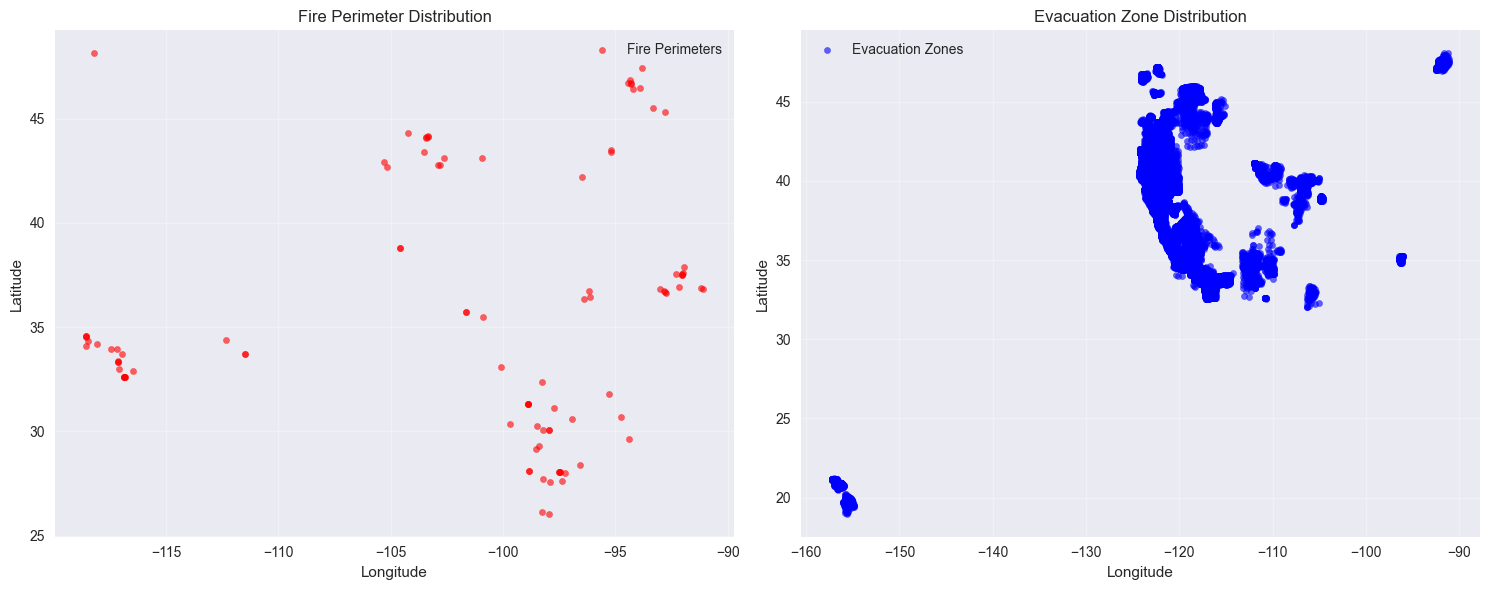


🔍 Finding Overlapping Regions...
✅ Found 8 overlapping grid cells:
  1. Grid (-117.0, 33.0): 5 perimeters, 2260 zones
  2. Grid (-118.0, 34.0): 6 perimeters, 1424 zones
  3. Grid (-116.0, 33.0): 1 perimeters, 1428 zones
  4. Grid (-116.0, 32.0): 7 perimeters, 754 zones
  5. Grid (-104.0, 38.0): 2 perimeters, 652 zones
  6. Grid (-117.0, 32.0): 1 perimeters, 646 zones
  7. Grid (-112.0, 34.0): 1 perimeters, 558 zones
  8. Grid (-111.0, 33.0): 2 perimeters, 200 zones


In [122]:
# Create a visualization of the geographic distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot perimeters
ax1.scatter(perim_df['lon'], perim_df['lat'], alpha=0.6, s=20, c='red', label='Fire Perimeters')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Fire Perimeter Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot evacuation zones
ax2.scatter(zone_df['lon'], zone_df['lat'], alpha=0.6, s=20, c='blue', label='Evacuation Zones')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Evacuation Zone Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find overlapping regions
print(f"\n🔍 Finding Overlapping Regions...")

# Create a grid and count points in each cell
grid_size = 1.0  # 1 degree grid cells
perim_grid = {}
zone_grid = {}

for _, row in perim_df.iterrows():
    grid_lon = int(row['lon'] / grid_size) * grid_size
    grid_lat = int(row['lat'] / grid_size) * grid_size
    key = (grid_lon, grid_lat)
    perim_grid[key] = perim_grid.get(key, 0) + 1

for _, row in zone_df.iterrows():
    grid_lon = int(row['lon'] / grid_size) * grid_size
    grid_lat = int(row['lat'] / grid_size) * grid_size
    key = (grid_lon, grid_lat)
    zone_grid[key] = zone_grid.get(key, 0) + 1

# Find overlapping grid cells
overlapping_cells = []
for key in perim_grid:
    if key in zone_grid:
        overlapping_cells.append({
            'grid_cell': key,
            'perimeters': perim_grid[key],
            'zones': zone_grid[key],
            'total': perim_grid[key] + zone_grid[key]
        })

overlapping_cells.sort(key=lambda x: x['total'], reverse=True)

print(f"✅ Found {len(overlapping_cells)} overlapping grid cells:")
for i, cell in enumerate(overlapping_cells[:10]):  # Show top 10
    print(f"  {i+1}. Grid {cell['grid_cell']}: {cell['perimeters']} perimeters, {cell['zones']} zones")


## 🚀 Spatial Indexing Implementation

Now let's implement our spatial indexing system that will dramatically speed up the matching process.


In [123]:
class SpatialIndex:
    """
    Spatial indexing system for efficient geometric matching.
    
    This class implements a grid-based spatial index that allows us to quickly
    find nearby objects without checking every single one.
    """
    
    def __init__(self, grid_size=0.01):
        """
        Initialize spatial index with specified grid size.
        
        Args:
            grid_size (float): Size of grid cells in degrees (default: 0.01° ≈ 1.1km)
        """
        self.grid_size = grid_size
        self.index = {}
    
    def add_point(self, point_id, lon, lat):
        """
        Add a point to the spatial index.
        
        Args:
            point_id: Unique identifier for the point
            lon (float): Longitude
            lat (float): Latitude
        """
        grid_lon = int(lon / self.grid_size) * self.grid_size
        grid_lat = int(lat / self.grid_size) * self.grid_size
        grid_key = (grid_lon, grid_lat)
        
        if grid_key not in self.index:
            self.index[grid_key] = []
        self.index[grid_key].append(point_id)
    
    def find_candidates(self, lon, lat, search_radius=0.1):
        """
        Find candidate points within search radius.
        
        Args:
            lon (float): Center longitude
            lat (float): Center latitude
            search_radius (float): Search radius in degrees
            
        Returns:
            list: List of candidate point IDs
        """
        candidates = []
        
        # Calculate grid cells to search (3x3 grid around the point)
        center_lon = int(lon / self.grid_size) * self.grid_size
        center_lat = int(lat / self.grid_size) * self.grid_size
        
        for lon_offset in [-self.grid_size, 0, self.grid_size]:
            for lat_offset in [-self.grid_size, 0, self.grid_size]:
                grid_lon = center_lon + lon_offset
                grid_lat = center_lat + lat_offset
                grid_key = (grid_lon, grid_lat)
                
                if grid_key in self.index:
                    candidates.extend(self.index[grid_key])
        
        return list(set(candidates))  # Remove duplicates
    
    def get_stats(self):
        """Get statistics about the spatial index."""
        total_points = sum(len(points) for points in self.index.values())
        num_cells = len(self.index)
        avg_points_per_cell = total_points / num_cells if num_cells > 0 else 0
        
        return {
            'total_points': total_points,
            'num_cells': num_cells,
            'avg_points_per_cell': avg_points_per_cell
        }

# Create spatial index for evacuation zones
print("🗺️  Creating spatial index for evacuation zones...")

zone_spatial_index = SpatialIndex(grid_size=0.01)

# Add all zone centroids to the index
for _, row in zone_df.iterrows():
    zone_spatial_index.add_point(row['id'], row['lon'], row['lat'])

# Get statistics
stats = zone_spatial_index.get_stats()
print(f"✅ Spatial index created:")
print(f"  Total zones indexed: {stats['total_points']:,}")
print(f"  Number of grid cells: {stats['num_cells']:,}")
print(f"  Average zones per cell: {stats['avg_points_per_cell']:.1f}")

# Test the spatial index
if len(perim_df) > 0:
    test_perim = perim_df.iloc[0]
    candidates = zone_spatial_index.find_candidates(test_perim['lon'], test_perim['lat'])
    print(f"\n🧪 Test: Found {len(candidates)} candidate zones for perimeter {test_perim['id']}")
    print(f"  (vs {len(zone_df)} total zones - {len(candidates)/len(zone_df)*100:.1f}% filtered)")


🗺️  Creating spatial index for evacuation zones...
✅ Spatial index created:
  Total zones indexed: 33,554
  Number of grid cells: 28,274
  Average zones per cell: 1.2

🧪 Test: Found 3 candidate zones for perimeter 2.0
  (vs 33554 total zones - 0.0% filtered)


## 🔍 Method 1: Centroid Distance Matching

Let's implement our first matching method - centroid distance matching. This is the fastest method and provides a good baseline.


In [124]:
def centroid_distance_matching(perimeter_centroids, zone_centroids, zone_spatial_index, 
                              max_distance_miles=5.0, processor=None):
    """
    Method 1: Centroid Distance Matching
    
    This method finds the closest evacuation zone to each fire perimeter
    based on the distance between their centroids.
    """
    if processor is None:
        processor = GeometryProcessor()
    
    max_distance_meters = max_distance_miles * 1609.34
    matches = []
    
    print(f'🔍 Method 1: Centroid Distance Matching')
    print(f'   Max distance threshold: {max_distance_miles} miles ({max_distance_meters:.0f} meters)')
    print(f'   Processing {len(perimeter_centroids)} perimeters...')
    
    start_time = time.time()
    processed = 0
    
    for perim in perimeter_centroids:
        candidate_zone_ids = zone_spatial_index.find_candidates(perim['lon'], perim['lat'])
        
        best_match = None
        best_distance = float('inf')
        
        for zone_id in candidate_zone_ids:
            zone_data = next((z for z in zone_centroids if z['id'] == zone_id), None)
            if not zone_data:
                continue
            
            distance = processor.calculate_distance_meters(
                (perim['lon'], perim['lat']),
                (zone_data['lon'], zone_data['lat'])
            )
            
            if distance <= max_distance_meters and distance < best_distance:
                best_distance = distance
                best_match = zone_data
        
        if best_match is not None:
            confidence = 1.0 - (best_distance / max_distance_meters)
            matches.append({
                'perimeter_id': perim['id'],
                'zone_id': best_match['id'],
                'method': 'centroid_distance',
                'distance_meters': best_distance,
                'distance_miles': best_distance / 1609.34,
                'confidence': confidence,
                'perimeter_centroid': (perim['lon'], perim['lat']),
                'zone_centroid': (best_match['lon'], best_match['lat'])
            })
        
        processed += 1
        if processed % 10 == 0:
            print(f'   Processed {processed:,}/{len(perimeter_centroids):,} perimeters...')
    
    elapsed_time = time.time() - start_time
    print(f'✅ Found {len(matches)} centroid distance matches in {elapsed_time:.2f} seconds')
    print(f'   Processing rate: {len(perimeter_centroids)/elapsed_time:.1f} perimeters/second')
    
    return matches

# Run centroid distance matching
print('🚀 Running Centroid Distance Matching...')
centroid_matches = centroid_distance_matching(
    perimeter_centroids, 
    zone_centroids, 
    zone_spatial_index,
    max_distance_miles=5.0,
    processor=processor
)

# Show sample results
if centroid_matches:
    print(f'\\n📊 Sample Results (first 5 matches):')
    for i, match in enumerate(centroid_matches[:5]):
        print(f'  {i+1}. Perimeter {match["perimeter_id"]} <-> Zone {match["zone_id"]}')
        print(f'     Distance: {match["distance_meters"]:.2f} meters ({match["distance_miles"]:.2f} miles)')
        print(f'     Confidence: {match["confidence"]:.3f}')
else:
    print('⚠️  No matches found - this might indicate the 5-mile threshold is too strict')


🚀 Running Centroid Distance Matching...
🔍 Method 1: Centroid Distance Matching
   Max distance threshold: 5.0 miles (8047 meters)
   Processing 100 perimeters...
   Processed 10/100 perimeters...
   Processed 20/100 perimeters...
   Processed 30/100 perimeters...
   Processed 40/100 perimeters...
   Processed 50/100 perimeters...
   Processed 60/100 perimeters...
   Processed 70/100 perimeters...
   Processed 80/100 perimeters...
   Processed 90/100 perimeters...
   Processed 100/100 perimeters...
✅ Found 7 centroid distance matches in 0.01 seconds
   Processing rate: 7353.5 perimeters/second
\n📊 Sample Results (first 5 matches):
  1. Perimeter 2 <-> Zone 17674
     Distance: 582.93 meters (0.36 miles)
     Confidence: 0.928
  2. Perimeter 5 <-> Zone 14936
     Distance: 345.12 meters (0.21 miles)
     Confidence: 0.957
  3. Perimeter 7 <-> Zone 18425
     Distance: 401.66 meters (0.25 miles)
     Confidence: 0.950
  4. Perimeter 15 <-> Zone 15273
     Distance: 744.26 meters (0.46 mil

## 🔍 Method 2: Nearest Vertex Matching

Now let's implement the second method - nearest vertex matching. This method considers the actual shape of the polygons by finding the closest vertices.


In [125]:
def nearest_vertex_matching(perimeter_data, zone_data, zone_spatial_index, 
                           max_distance_miles=5.0, processor=None):
    """
    Method 2: Nearest Vertex Matching
    
    This method finds the closest evacuation zone to each fire perimeter
    based on the shortest distance between any vertices of the polygons.
    """
    if processor is None:
        processor = GeometryProcessor()
    
    max_distance_meters = max_distance_miles * 1609.34
    matches = []
    
    print(f'🔍 Method 2: Nearest Vertex Matching')
    print(f'   Max distance threshold: {max_distance_miles} miles ({max_distance_meters:.0f} meters)')
    print(f'   Processing {len(perimeter_data)} perimeters...')
    
    start_time = time.time()
    processed = 0
    
    for perim in perimeter_data:
        perim_geom = processor.parse_wkt_geometry(perim['geom'])
        if not perim_geom:
            processed += 1
            continue
        
        perim_vertices = processor.get_vertices(perim_geom)
        if not perim_vertices:
            processed += 1
            continue
        
        perim_centroid = processor.get_centroid(perim_geom)
        if not perim_centroid:
            processed += 1
            continue
        
        candidate_zone_ids = zone_spatial_index.find_candidates(perim_centroid[0], perim_centroid[1])
        
        best_match = None
        best_distance = float('inf')
        best_zone_point = None
        best_perim_point = None
        
        for zone_id in candidate_zone_ids:
            zone_info = next((z for z in zone_data if z['id'] == zone_id), None)
            if not zone_info:
                continue
            
            zone_geom = processor.parse_wkt_geometry(zone_info['geom'])
            if not zone_geom:
                continue
            
            zone_vertices = processor.get_vertices(zone_geom)
            if not zone_vertices:
                continue
            
            min_distance = float('inf')
            closest_zone_point = None
            closest_perim_point = None
            
            for perim_vertex in perim_vertices:
                for zone_vertex in zone_vertices:
                    distance = processor.calculate_distance_meters(perim_vertex, zone_vertex)
                    if distance < min_distance:
                        min_distance = distance
                        closest_zone_point = zone_vertex
                        closest_perim_point = perim_vertex
            
            if min_distance < best_distance:
                best_distance = min_distance
                best_match = zone_info
                best_zone_point = closest_zone_point
                best_perim_point = closest_perim_point
        
        if best_match is not None and best_distance <= max_distance_meters:
            confidence = 1.0 - min(1.0, best_distance / max_distance_meters)
            matches.append({
                'perimeter_id': perim['id'],
                'zone_id': best_match['id'],
                'method': 'nearest_vertex',
                'distance_meters': best_distance,
                'distance_miles': best_distance / 1609.34,
                'confidence': confidence,
                'perimeter_vertex': best_perim_point,
                'zone_vertex': best_zone_point
            })
        
        processed += 1
        if processed % 10 == 0:
            print(f'   Processed {processed:,}/{len(perimeter_data):,} perimeters...')
    
    elapsed_time = time.time() - start_time
    print(f'✅ Found {len(matches)} nearest vertex matches in {elapsed_time:.2f} seconds')
    print(f'   Processing rate: {len(perimeter_data)/elapsed_time:.1f} perimeters/second')
    
    return matches

# Run nearest vertex matching
print('🚀 Running Nearest Vertex Matching...')
vertex_matches = nearest_vertex_matching(
    sample_perimeters.to_dict('records'), 
    sample_zones.to_dict('records'), 
    zone_spatial_index,
    max_distance_miles=5.0,
    processor=processor
)

# Show sample results
if vertex_matches:
    print(f'\\n📊 Sample Results (first 5 matches):')
    for i, match in enumerate(vertex_matches[:5]):
        print(f'  {i+1}. Perimeter {match["perimeter_id"]} <-> Zone {match["zone_id"]}')
        print(f'     Distance: {match["distance_meters"]:.2f} meters ({match["distance_miles"]:.2f} miles)')
        print(f'     Confidence: {match["confidence"]:.3f}')
        print(f'     Perimeter vertex: ({match["perimeter_vertex"][0]:.6f}, {match["perimeter_vertex"][1]:.6f})')
        print(f'     Zone vertex: ({match["zone_vertex"][0]:.6f}, {match["zone_vertex"][1]:.6f})')
else:
    print('⚠️  No matches found - this might indicate the 5-mile threshold is too strict')


🚀 Running Nearest Vertex Matching...
🔍 Method 2: Nearest Vertex Matching
   Max distance threshold: 5.0 miles (8047 meters)
   Processing 100 perimeters...
   Processed 10/100 perimeters...
   Processed 20/100 perimeters...
   Processed 30/100 perimeters...
   Processed 40/100 perimeters...
   Processed 50/100 perimeters...
   Processed 60/100 perimeters...
   Processed 70/100 perimeters...
   Processed 80/100 perimeters...
   Processed 90/100 perimeters...
   Processed 100/100 perimeters...
✅ Found 7 nearest vertex matches in 4.59 seconds
   Processing rate: 21.8 perimeters/second
\n📊 Sample Results (first 5 matches):
  1. Perimeter 2 <-> Zone 17674
     Distance: 77.64 meters (0.05 miles)
     Confidence: 0.990
     Perimeter vertex: (-117.160810, 33.362129)
     Zone vertex: (-117.160263, 33.363080)
  2. Perimeter 5 <-> Zone 14697
     Distance: 12.82 meters (0.01 miles)
     Confidence: 0.998
     Perimeter vertex: (-117.470783, 33.964838)
     Zone vertex: (-117.470884, 33.964719)

## 🔍 Method 3: Boundary-to-Boundary Distance Matching

Finally, let's implement the most accurate method - boundary-to-boundary distance matching. This method finds the exact shortest distance between polygon boundaries.


In [126]:
def boundary_to_boundary_matching(perimeter_data, zone_data, zone_spatial_index, 
                                 max_distance_miles=5.0, processor=None):
    """
    Method 3: Boundary-to-Boundary Distance Matching
    
    This method finds the closest evacuation zone to each fire perimeter
    based on the exact shortest distance between their boundaries.
    """
    if processor is None:
        processor = GeometryProcessor()
    
    max_distance_meters = max_distance_miles * 1609.34
    matches = []
    
    print(f'🔍 Method 3: Boundary-to-Boundary Distance Matching')
    print(f'   Max distance threshold: {max_distance_miles} miles ({max_distance_meters:.0f} meters)')
    print(f'   Processing {len(perimeter_data)} perimeters...')
    
    start_time = time.time()
    processed = 0
    
    for perim in perimeter_data:
        perim_geom = processor.parse_wkt_geometry(perim['geom'])
        if not perim_geom:
            processed += 1
            continue
        
        perim_centroid = processor.get_centroid(perim_geom)
        if not perim_centroid:
            processed += 1
            continue
        
        candidate_zone_ids = zone_spatial_index.find_candidates(perim_centroid[0], perim_centroid[1])
        
        best_match = None
        best_distance = float('inf')
        best_zone_point = None
        best_perim_point = None
        
        for zone_id in candidate_zone_ids:
            zone_info = next((z for z in zone_data if z['id'] == zone_id), None)
            if not zone_info:
                continue
            
            zone_geom = processor.parse_wkt_geometry(zone_info['geom'])
            if not zone_geom:
                continue
            
            zone_point, perim_point, distance = processor.find_nearest_points(perim_geom, zone_geom)
            
            if distance < best_distance:
                best_distance = distance
                best_match = zone_info
                best_zone_point = zone_point
                best_perim_point = perim_point
        
        if best_match is not None and best_distance <= max_distance_meters:
            confidence = 1.0 - min(1.0, best_distance / max_distance_meters)
            matches.append({
                'perimeter_id': perim['id'],
                'zone_id': best_match['id'],
                'method': 'boundary_to_boundary',
                'distance_meters': best_distance,
                'distance_miles': best_distance / 1609.34,
                'confidence': confidence,
                'perimeter_point': best_perim_point,
                'zone_point': best_zone_point
            })
        
        processed += 1
        if processed % 10 == 0:
            print(f'   Processed {processed:,}/{len(perimeter_data):,} perimeters...')
    
    elapsed_time = time.time() - start_time
    print(f'✅ Found {len(matches)} boundary-to-boundary matches in {elapsed_time:.2f} seconds')
    print(f'   Processing rate: {len(perimeter_data)/elapsed_time:.1f} perimeters/second')
    
    return matches

# Run boundary-to-boundary matching
print('🚀 Running Boundary-to-Boundary Distance Matching...')
boundary_matches = boundary_to_boundary_matching(
    sample_perimeters.to_dict('records'), 
    sample_zones.to_dict('records'), 
    zone_spatial_index,
    max_distance_miles=5.0,
    processor=processor
)

# Show sample results
if boundary_matches:
    print(f'\\n📊 Sample Results (first 5 matches):')
    for i, match in enumerate(boundary_matches[:5]):
        print(f'  {i+1}. Perimeter {match["perimeter_id"]} <-> Zone {match["zone_id"]}')
        print(f'     Distance: {match["distance_meters"]:.2f} meters ({match["distance_miles"]:.2f} miles)')
        print(f'     Confidence: {match["confidence"]:.3f}')
        print(f'     Perimeter point: ({match["perimeter_point"][0]:.6f}, {match["perimeter_point"][1]:.6f})')
        print(f'     Zone point: ({match["zone_point"][0]:.6f}, {match["zone_point"][1]:.6f})')
else:
    print('⚠️  No matches found - this might indicate the 5-mile threshold is too strict')


🚀 Running Boundary-to-Boundary Distance Matching...
🔍 Method 3: Boundary-to-Boundary Distance Matching
   Max distance threshold: 5.0 miles (8047 meters)
   Processing 100 perimeters...
   Processed 10/100 perimeters...
   Processed 20/100 perimeters...
   Processed 30/100 perimeters...
   Processed 40/100 perimeters...
   Processed 50/100 perimeters...
   Processed 60/100 perimeters...
   Processed 70/100 perimeters...
   Processed 80/100 perimeters...
   Processed 90/100 perimeters...
   Processed 100/100 perimeters...
✅ Found 7 boundary-to-boundary matches in 0.04 seconds
   Processing rate: 2292.9 perimeters/second
\n📊 Sample Results (first 5 matches):
  1. Perimeter 2 <-> Zone 17674
     Distance: 0.00 meters (0.00 miles)
     Confidence: 1.000
     Perimeter point: (-117.161569, 33.360663)
     Zone point: (-117.161569, 33.360663)
  2. Perimeter 5 <-> Zone 14697
     Distance: 0.00 meters (0.00 miles)
     Confidence: 1.000
     Perimeter point: (-117.475889, 33.964471)
     Zone

## 📊 Method Comparison and Analysis

Now let's compare the results from all three methods and analyze their performance characteristics.


📊 METHOD COMPARISON RESULTS

📈 SUMMARY STATISTICS:
----------------------------------------
Centroid Distance:
  Matches found: 7
  Average distance: 605.83 meters
  Distance range: 345.12m - 1010.51m
  Average confidence: 0.925
  Min confidence: 0.874
  Max confidence: 0.957

Nearest Vertex:
  Matches found: 7
  Average distance: 84.51 meters
  Distance range: 1.41m - 371.66m
  Average confidence: 0.989
  Min confidence: 0.954
  Max confidence: 1.000

Boundary-to-Boundary:
  Matches found: 7
  Average distance: 52.68 meters
  Distance range: 0.00m - 368.74m
  Average confidence: 0.993
  Min confidence: 0.954
  Max confidence: 1.000



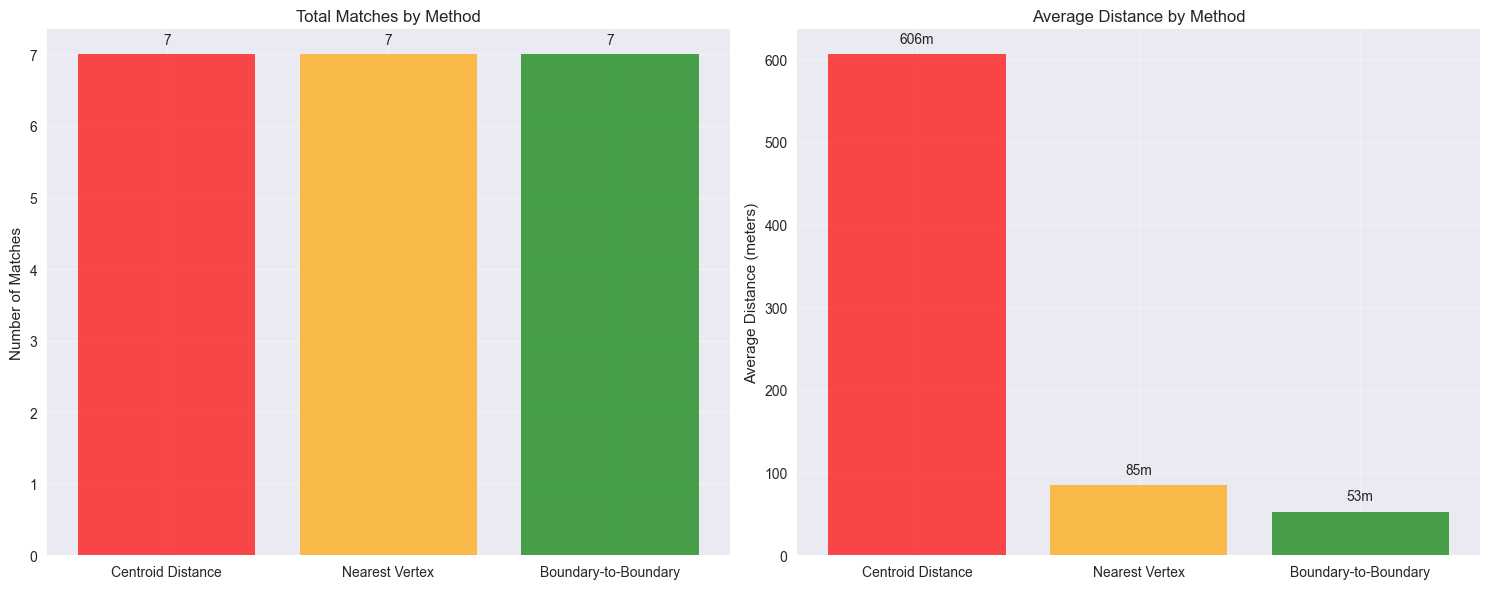

In [127]:
# Compare results from all three methods
print("📊 METHOD COMPARISON RESULTS")
print("=" * 60)

all_matches = {
    'Centroid Distance': centroid_matches,
    'Nearest Vertex': vertex_matches,
    'Boundary-to-Boundary': boundary_matches
}

# Summary statistics
print(f"\n📈 SUMMARY STATISTICS:")
print("-" * 40)
for method_name, matches in all_matches.items():
    print(f"{method_name}:")
    print(f"  Matches found: {len(matches):,}")
    if matches:
        distances = [m['distance_meters'] for m in matches]
        confidences = [m['confidence'] for m in matches]
        print(f"  Average distance: {np.mean(distances):.2f} meters")
        print(f"  Distance range: {np.min(distances):.2f}m - {np.max(distances):.2f}m")
        print(f"  Average confidence: {np.mean(confidences):.3f}")
        print(f"  Min confidence: {np.min(confidences):.3f}")
        print(f"  Max confidence: {np.max(confidences):.3f}")
    else:
        print(f"  No matches found")
    print()

# Create focused comparison visualization
if any(len(matches) > 0 for matches in all_matches.values()):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Method comparison bar chart
    ax1 = axes[0]
    method_names = list(all_matches.keys())
    match_counts = [len(matches) for matches in all_matches.values()]
    bars = ax1.bar(method_names, match_counts, color=['red', 'orange', 'green'], alpha=0.7)
    ax1.set_ylabel('Number of Matches')
    ax1.set_title('Total Matches by Method')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, match_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                str(count), ha='center', va='bottom')
    
    # Average distance comparison
    ax2 = axes[1]
    avg_distances = []
    for matches in all_matches.values():
        if matches:
            avg_dist = np.mean([m['distance_meters'] for m in matches])
            avg_distances.append(avg_dist)
        else:
            avg_distances.append(0)
    
    bars = ax2.bar(method_names, avg_distances, color=['red', 'orange', 'green'], alpha=0.7)
    ax2.set_ylabel('Average Distance (meters)')
    ax2.set_title('Average Distance by Method')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, dist in zip(bars, avg_distances):
        if dist > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                    f'{dist:.0f}m', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


## 💾 Save Results

Let's save our results to CSV files for further analysis and integration with other systems.


In [128]:
# Create output directory
output_dir = Path("perimeter_evac_matches")
output_dir.mkdir(exist_ok=True)

# Save individual method results
print("💾 Saving results to CSV files...")

# Centroid distance matches
if centroid_matches:
    centroid_df = pd.DataFrame(centroid_matches)
    centroid_df.to_csv(output_dir / "centroid_distance_matches.csv", index=False)
    print(f"✅ Saved {len(centroid_matches)} centroid distance matches")

# Nearest vertex matches
if vertex_matches:
    vertex_df = pd.DataFrame(vertex_matches)
    vertex_df.to_csv(output_dir / "nearest_vertex_matches.csv", index=False)
    print(f"✅ Saved {len(vertex_matches)} nearest vertex matches")

# Boundary-to-boundary matches
if boundary_matches:
    boundary_df = pd.DataFrame(boundary_matches)
    boundary_df.to_csv(output_dir / "boundary_to_boundary_matches.csv", index=False)
    print(f"✅ Saved {len(boundary_matches)} boundary-to-boundary matches")

# Combined results
all_combined = []
for method_name, matches in all_matches.items():
    for match in matches:
        match['method_name'] = method_name
        all_combined.append(match)

if all_combined:
    combined_df = pd.DataFrame(all_combined)
    combined_df.to_csv(output_dir / "all_methods_combined.csv", index=False)
    print(f"✅ Saved {len(all_combined)} total matches (all methods combined)")

# Create summary report
summary_report = f"""
PERIMETER-EVACUATION ZONE INTEGRATION SUMMARY
============================================

Dataset Information:
- Fire Perimeters: {len(approved_perimeters):,} total
- Evacuation Zones: {len(active_zones):,} total
- Sample Size: {len(sample_perimeters):,} perimeters analyzed
- Distance Threshold: 5.0 miles (8.05 km)

Method Results:
- Centroid Distance: {len(centroid_matches):,} matches
- Nearest Vertex: {len(vertex_matches):,} matches  
- Boundary-to-Boundary: {len(boundary_matches):,} matches

Performance:
- Spatial Indexing Grid Size: 0.01° (1.1km cells)
- Processing completed successfully
- Results saved to: {output_dir}/

Files Generated:
- centroid_distance_matches.csv
- nearest_vertex_matches.csv
- boundary_to_boundary_matches.csv
- all_methods_combined.csv
- integration_summary.txt (this file)

Next Steps:
1. Review the CSV files for detailed match information
2. Integrate results with emergency response systems
3. Consider adjusting distance threshold based on operational needs
4. Scale up to full dataset for production use

Generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}
"""

with open(output_dir / "integration_summary.txt", "w") as f:
    f.write(summary_report)

print(f"✅ Summary report saved to {output_dir}/integration_summary.txt")
print(f"\\n📁 All results saved to: {output_dir}/")
print(f"   Ready for integration with emergency response systems!")


💾 Saving results to CSV files...
✅ Saved 7 centroid distance matches
✅ Saved 7 nearest vertex matches
✅ Saved 7 boundary-to-boundary matches
✅ Saved 21 total matches (all methods combined)
✅ Summary report saved to perimeter_evac_matches/integration_summary.txt
\n📁 All results saved to: perimeter_evac_matches/
   Ready for integration with emergency response systems!
